Global imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

Different options for datasets

In [2]:
mnist = keras.datasets.mnist                  # 28x28, handwritten digits 0-9
fashion_mnist = keras.datasets.fashion_mnist
# couple of more

Pivotal Parameters

In [3]:
dataset = mnist
ratio_D1_D2 = 14
ratio_test_val: 6
latent_vector_size = 12

lr_autoencoder = 0.001
loss_autoencoder = "mse"
optimizer_autoencoder = "adam"
epochs_autoencoder = 5

lr_classifier = 0.001
loss_classifier = "categorical_crossentropy"
optimizer_classifier = "adam"
epochs_classifier = 8
freeze_encoder = False

n_autoencoder_reconstructions = 16
show_tsne = True

In [4]:
(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [5]:
from utils.normalize import normalize

x_train = normalize(x_train)
x_test = normalize(x_test)

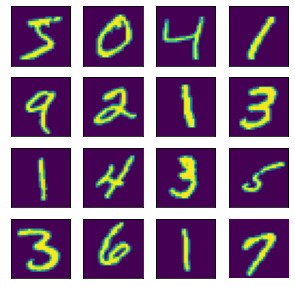

In [6]:
from utils.visualize import show_image_chunk
show_image_chunk(x_train[:16])

Size original data set:   60000 

Size training set D1:     56000
Size training set D2:     4000
----------------------------------------------------
Distribution of classes in each dataset:



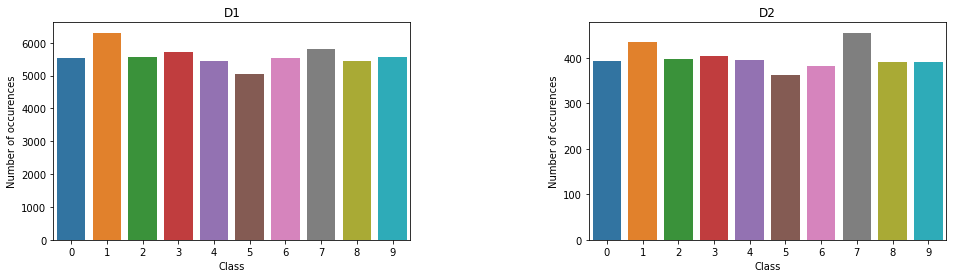

In [7]:
# divide data into D1 and D2. Test data will still be the same
from utils.data import split_data_sets
from utils.visualize import plot_distributions

print("Size original data set:  ", len(x_train), "\n")

fraq_D1 = ratio_D1_D2 / (ratio_D1_D2 + 1)
(x_train_d1, y_train_d1), (x_train_d2, y_train_d2) = split_data_sets(fraq_D1, x_train, y_train)

print("Size training set D1:    ", len(x_train_d1))
print("Size training set D2:    ", len(x_train_d2))
print("-"*52)
print("Distribution of classes in each dataset:\n")
plot_distributions([y_train_d1, y_train_d2], ["D1", "D2"])

In [8]:
# one hot encoding of categories
from tensorflow.keras.utils import to_categorical

y_train_d1 = to_categorical(y_train_d1)
y_train_d2 = to_categorical(y_train_d2)

test_labels = y_test                                  # save numerical format for later
y_test = to_categorical(y_test)

In [9]:
from models.encoder import deep_conv_encoder
from models.decoder import deep_conv_decoder

encoder = deep_conv_encoder((28, 28), latent_vector_size)
decoder = deep_conv_decoder(latent_vector_size, (28, 28))

def deep_autoencoder(encoder, decoder):
    #input_layer = keras.Input(shape=input_shape + (1, ))
    input_layer = tf.keras.Input(shape=encoder.input_shape[1:])
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    return tf.keras.Model(input_layer, decoded)

autoencoder = deep_autoencoder(encoder, decoder)

In [10]:
from models.classifier import deep_classifier

classifier_C1 = deep_classifier(10, encoder=encoder)
classifier_C2 = deep_classifier(10, input_shape=(28, 28))

In [11]:
from utils.callback import TrainingCallback
from utils.optimizer import optimizer

logs_autoencoder = []
autoencoder.compile(optimizer=optimizer(optimizer_autoencoder, lr_autoencoder), loss=loss_autoencoder)
autoencoder.fit(x_train_d1, x_train_d1, epochs=epochs_autoencoder, batch_size=64, validation_data=(x_test, x_test), verbose=1, callbacks=[TrainingCallback(logs_autoencoder)])


Epoch 1/5
875/875 [==============================] - 29s 33ms/step - loss: 0.0413 - val_loss: 0.0208
Epoch 2/5
875/875 [==============================] - 28s 32ms/step - loss: 0.0200 - val_loss: 0.0186
Epoch 3/5
875/875 [==============================] - 28s 32ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 4/5
875/875 [==============================] - 29s 33ms/step - loss: 0.0171 - val_loss: 0.0167
Epoch 5/5
875/875 [==============================] - 28s 32ms/step - loss: 0.0164 - val_loss: 0.0163


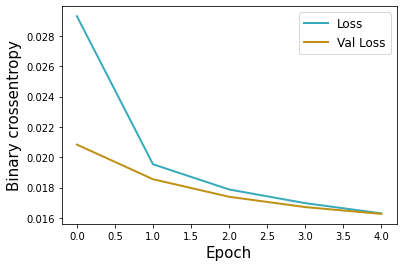

In [12]:
from utils.visualize import plot_logs
plot_logs("Autoencoder training", [logs_autoencoder], "loss", ["Loss"], "Binary crossentropy")

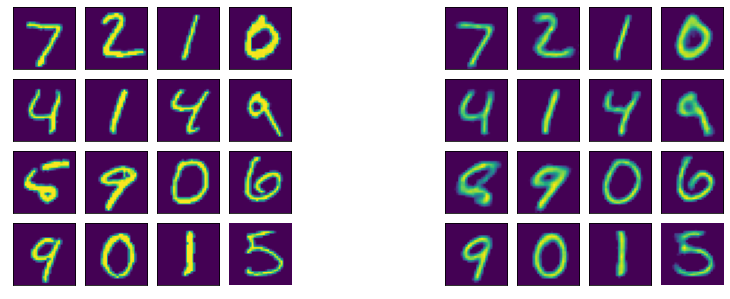

In [13]:
from utils.visualize import show_image_chunks
transformed_images = autoencoder.predict(x_test).reshape((len(x_test), 28, 28))

show_image_chunks([x_test[:n_autoencoder_reconstructions], transformed_images[:n_autoencoder_reconstructions]])
#show_image_chunk(x_test[:16])
#show_image_chunk(transformed_images[:16])


In [14]:
# Now that autoencoder is trained, the encoder module can be used for other things
# encoder = keras.Model(input_layer, latent_layer)
from utils.visualize import tsne_plot

compressed_image_representations = encoder.predict(x_test)
tsne_plot(compressed_image_representations[:200], test_labels[:200])

(12,)

In [16]:
if freeze_encoder:
    encoder.trainable = False

logs_C1 = []
classifier_C1.compile(optimizer=optimizer(optimizer_classifier, lr_classifier), loss="categorical_crossentropy", metrics=['accuracy'])
classifier_C1.fit(x_train_d2, y_train_d2, epochs=epochs_classifier, batch_size=64, validation_data=(x_test[:128], y_test[:128]), verbose=1, callbacks=[TrainingCallback(logs_C1)])
loss_C1, acc_C1 = classifier_C1.evaluate(x_test, y_test)

Epoch 1/8
63/63 [==============================] - 2s 20ms/step - loss: 1.8644 - accuracy: 0.4253 - val_loss: 0.4264 - val_accuracy: 0.8672
Epoch 2/8
63/63 [==============================] - 1s 16ms/step - loss: 0.2320 - accuracy: 0.9268 - val_loss: 0.2044 - val_accuracy: 0.9141
Epoch 3/8
63/63 [==============================] - 1s 16ms/step - loss: 0.1245 - accuracy: 0.9606 - val_loss: 0.1244 - val_accuracy: 0.9531
Epoch 4/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0699 - accuracy: 0.9821 - val_loss: 0.0951 - val_accuracy: 0.9688
Epoch 5/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0588 - accuracy: 0.9860 - val_loss: 0.1337 - val_accuracy: 0.9453
Epoch 6/8
63/63 [==============================] - 1s 17ms/step - loss: 0.0350 - accuracy: 0.9914 - val_loss: 0.0835 - val_accuracy: 0.9688
Epoch 7/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0170 - accuracy: 0.9978 - val_loss: 0.1166 - val_accuracy: 0.9609
Epoch 8/8
313/313 [=

In [18]:
logs_C2 = []

classifier_C2.compile(optimizer=optimizer(optimizer_classifier, lr_classifier), loss=loss_classifier, metrics=['accuracy'])
classifier_C2.fit(x_train_d2, y_train_d2, epochs=epochs_classifier, batch_size=64, validation_data=(x_test[:128], y_test[:128]), verbose=1, callbacks=[TrainingCallback(logs_C2)])
loss_C2, acc_C2 = classifier_C2.evaluate(x_test, y_test)

Epoch 1/8
63/63 [==============================] - 2s 19ms/step - loss: 1.0303 - accuracy: 0.7285 - val_loss: 0.2405 - val_accuracy: 0.9375
Epoch 2/8
63/63 [==============================] - 1s 17ms/step - loss: 0.1769 - accuracy: 0.9447 - val_loss: 0.1642 - val_accuracy: 0.9688
Epoch 3/8
63/63 [==============================] - 1s 17ms/step - loss: 0.1085 - accuracy: 0.9675 - val_loss: 0.1513 - val_accuracy: 0.9531
Epoch 4/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0939 - accuracy: 0.9708 - val_loss: 0.0821 - val_accuracy: 0.9766
Epoch 5/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0309 - accuracy: 0.9931 - val_loss: 0.0528 - val_accuracy: 0.9922
Epoch 6/8
63/63 [==============================] - 1s 16ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0488 - val_accuracy: 0.9844
Epoch 7/8
63/63 [==============================] - 1s 17ms/step - loss: 0.0057 - accuracy: 0.9996 - val_loss: 0.0453 - val_accuracy: 0.9844
Epoch 8/8
313/313 [=

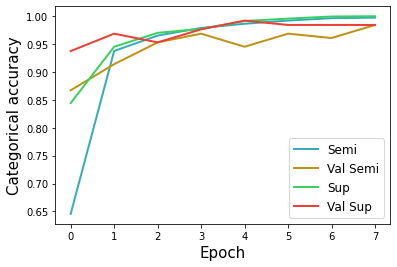

In [19]:
plot_logs("Accuracy", [logs_C1, logs_C2], "accuracy", ["Semi", "Sup"], "Categorical accuracy")

In [20]:
print("Test accuracy C1:", acc_C1)
print("Test accuracy C2:", acc_C2)

Test accuracy C1: 0.9575999975204468
Test accuracy C2: 0.9490000009536743


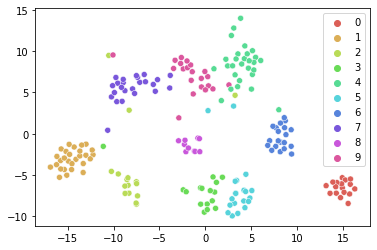

In [21]:
compressed_image_representations = encoder.predict(x_test)
tsne_plot(compressed_image_representations[:200], test_labels[:200])